In [1]:
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def plot_path(points, perm, save_plot=False, ax=plt, title=""):
    xs = [points[perm[i]][0] for i in range(len(points))]
    ys = [points[perm[i]][1] for i in range(len(points))]
    xs.append(points[perm[0]][0])
    ys.append(points[perm[0]][1])
    ax.plot(xs, ys, marker='s', markerfacecolor='red')
    if ax != plt:
        ax.set_title(title)
    if save_plot:
        plt.ioff()
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='jpeg', bbox_inches="tight")
        plt.close()
        return Image.open(img_buf)
    elif ax == plt:
        ax.title(title)
        ax.show()


def plot_path_for_given_points(points, ax=plt, title=""):
    xs = [x1 for x1, _ in points] + [points[0][0]]
    ys = [y1 for _, y1 in points] + [points[0][1]]
    ax.plot(xs, ys, marker='s', markerfacecolor='red')
    if ax == plt:
        ax.title(title)
        ax.show()
    else:
        ax.set_title(title)


def plot_energy(energy, ax=plt):
    ax.plot([ind for ind in range(len(energy))], energy)
    if ax == plt:
        ax.title("Energy plot")
        ax.show()
    else:
        ax.set_title("Energy plot")

def plot_temperature(temperature, ax=plt):
    ax.plot([ind for ind in range(len(temperature))], temperature)
    if ax == plt:
        ax.title("Temperature plot")
        ax.show()
    else:
        ax.set_title("Temperature plot")


Generowanie chmur punktów

In [3]:
from numpy.random import multivariate_normal as mvn

def generate_numbers(left, right, size):
    return [np.random.uniform(left, right) for _ in range(size)]

def generate_uniform(size):
    return [(np.random.rand(), np.random.rand()) for _ in range(size)]

def euclid_dist(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)


def generate_clusters(cluster_size):
    cluster = []
    intervals = []
    for i in range(3):
        for j in range(3):
            intervals.append((i*10, i*10 + 2, j*10, j*10 + 2))

    for x1, y1, x2, y2 in intervals:
        cluster += [(w1, w2) for w1, w2 in zip(generate_numbers(x1, y1, cluster_size), generate_numbers(x2, y2, cluster_size))]
    return cluster


def generate_normal(size):
    sample1 = mvn([-5, -5], np.array([[1, 0], [0, 1]]), size = size)
    sample2 = mvn([5, 5], np.array([[1, 0], [0, 1]]), size = size)
    sample3 = mvn([-5, 5], np.array([[1, 0], [0, 1]]), size = size)
    sample4 = mvn([5, -5], np.array([[1, 0], [0, 1]]), size = size)
    return [(point[0], point[1]) for point in np.concatenate((sample1, sample2, sample3, sample4))]


3 warianty funkcji generującej sąsiadów

1 - zamienienie miejscami dwóch miast o indeksach a, a + 1
2 - zamienienie miejscami dwóch miast o indeksach a i b, a i b to dwa dowolne różne indeksy
3 - odwrócenie kolejności miast na dowolnym przedziale <a, b>

In [4]:
def generate_neighbor1(p):
    n = len(p)
    x1 = np.random.randint(0, n - 1)
    new_p = p[:]
    new_p[x1], new_p[x1 + 1] = new_p[x1 + 1], new_p[x1]
    return new_p


def generate_neighbor2(p):
    n = len(p)
    x1 = np.random.randint(0, n - 1)
    x2 = np.random.randint(x1 + 1, n)
    new_p = p[:]
    new_p[x1], new_p[x2] = new_p[x2], new_p[x1]
    return new_p


def generate_neighbor3(p):
    n = len(p)
    x1 = np.random.randint(0, n - 1)
    x2 = np.random.randint(x1 + 1, n)
    new_p = p[:]
    j = (x2 - x1) // 2
    for i in range(x1, x1 + j + 1):
        new_p[i], new_p[x2 + x1 - i] = new_p[x2 + x1 - i], new_p[i]
    return new_p

In [5]:
def calculate_energy_for_permutation(dist_mat, p):
    energy = 0
    for i in range(1, len(p)):
        energy += dist_mat[p[i]][p[i-1]]
    energy += dist_mat[p[-1]][p[0]]
    return energy

Prosta heurystyka zaczynająca ścieżkę w ustalonym mieście i za każdym razem wybierająca w danym momencie najbliższe miasto. Wyniki można porównać ze ścieżką otrzymaną
po wyżarzaniu.

In [6]:
def simple_salesman(points, ax=plt):
    n = len(points)
    path = [points[-1]]
    points.pop()
    last = points[0]
    for _ in range(n - 1):
        min_index = 0
        min_dist = euclid_dist(last, points[0])
        for i in range(1, len(points)):
            d = euclid_dist(last, points[i])
            if d < min_dist:
                min_dist = d
                min_index = i
        last = points.pop(min_index)
        path.append(last)

    path_length = 0
    for i in range(1, len(path)):
        path_length += euclid_dist(path[i], path[i-1])
    path_length += euclid_dist(path[-1], path[0])

    plot_path_for_given_points(path, ax=ax, title=f"Długość ścieżki(heurystyka): {np.round(path_length, 2)}")

Algorytm dynamiczny znajdujący optymalne rozwiązanie( złożoność czasowa to $O(2^{n} \cdot n^{2}) $, więc policzy maksymalnie dla 20 miast

In [7]:
def pop_count(number):
    count = 0
    while number:
        count += number % 2
        number //= 2
    return count


def to_bin(number):
    return to_bin(number // 2) + str(number%2) if number else ""

def optimal_salesman(points, ax=plt):
    n = len(points)
    matrix = [[euclid_dist(p1, p2) for p1 in points] for p2 in points]
    al = 1<<n
    dp = [[float("inf") for _ in range(n)] for _ in range(al)]
    parent = [[None for _ in range(n)] for _ in range(al)]
    dp[1][0] = 0
    for i in range(2, n + 1):
        for mask in range(al):
            if pop_count(mask) != i or not 1&mask:
                continue
            for city in range(1, n):
                bit_number = 1<<city
                if not bit_number & mask:
                    continue
                for last_city in range(n):
                    bit_number_last = 1<<last_city
                    if city == last_city or not bit_number_last&mask:
                        continue
                    if dp[mask][city] > dp[mask^bit_number][last_city] + matrix[city][last_city]:
                        dp[mask][city] = dp[mask^bit_number][last_city] + matrix[city][last_city]
                        parent[mask][city] = last_city

    ans = float("inf")
    cur_city = 0
    for city in range(1, n):
        if ans > dp[al - 1][city] + matrix[0][city]:
            ans = dp[al - 1][city] + matrix[0][city]
            cur_city = city

    ans_points = [points[cur_city]]
    mask = al - 1
    while cur_city:
        next_city = parent[mask][cur_city]
        ans_points.append(points[next_city])
        mask ^= 1<<cur_city
        cur_city = next_city

    plot_path_for_given_points(ans_points, ax=ax, title=f"Długość ścieżki optymalnej: {np.round(ans, 2)}")

#### Algorytm wyżarzania
Konkretnym stanem jest permutacja miast. Sąsiadów generuje jednym z wyżej wymienionych trzech sposobów. Funkcja temperatury jest funkcją wykładniczą
o ilorazie alpha ( rzędu 0.95 - 0.99 ). W głównej pętli programu, w której aktualizuje temperatury znajduje się jeszce jedna pętla. Jest po to aby
algorytm mógł zbadać większe sąsiedztwo dla ustalonego poziomu temperatury( wtedy wyniki były z reguły lepsze).
Funkcja obliczająca prawdopodobieństwo to $exp{\frac{-\Delta}{T}} $, gdzie $\Delta$ to zmiana energii przy przejściu do sąsiedniego stanu, a $T$ to temperatura.

In [8]:
def f(delta, T):
    return np.exp(-delta/T)


In [9]:
def annealing_salesman(points, neighbor_fun=generate_neighbor3, steps=1000, T0=50, alpha=0.99, no_of_iter=40, save_gif=False, ax=plt, ax1=None, ax2=None):
    n = len(points)
    dist_matrix = [[euclid_dist(points[i], points[j]) for i in range(n)] for j in range(n)]
    p = [i for i in range(n)]
    cur_energy = calculate_energy_for_permutation(dist_matrix, p)
    energy_states = [cur_energy]
    T = T0
    temperature = [T0]

    for i in range(steps):
        for _ in range(no_of_iter):
            new_state = neighbor_fun(p)
            next_energy = calculate_energy_for_permutation(dist_matrix, new_state)
            if next_energy < cur_energy:
                p = new_state
                cur_energy = next_energy
            else:
                probability = f(next_energy - cur_energy, T)
                if probability > np.random.uniform(0, 1):
                    p = new_state
                    cur_energy = next_energy
        if i % 20 == 0 and save_gif:
            frames.append(plot_path(points, p, save_plot=True))
        T *= alpha
        temperature.append(T)
        energy_states.append(cur_energy)


    plot_path(points, p, ax=ax, title=f"Długość ścieżki(wyżarzanie): {np.round(calculate_energy_for_permutation(dist_matrix, p), 2)}")
    if ax1 is not None:
        plot_energy(energy_states, ax=ax1)
        plot_temperature(temperature, ax=ax2)

## Wyniki działania algorytmu

In [10]:
def shuffle():
    for _ in range(2*m):
        a = np.random.randint(0, m - 1)
        b = np.random.randint(a + 1, m)
        sample_points[a], sample_points[b] = sample_points[b], sample_points[a]

In [11]:
def draw4(points):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
    plot_path_for_given_points(points[:], ax=ax1)
    simple_salesman(points[:], ax=ax2)
    optimal_salesman(points[:], ax=ax3)
    annealing_salesman(points[:], ax=ax4)


In [12]:
def draw_with_stats(points, **kwargs):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
    plot_path_for_given_points(sample_points[:], ax1)
    annealing_salesman(points[:], ax=ax2, ax1=ax3, ax2=ax4, **kwargs)

In [13]:
def draw_different_neighbors(points):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 4))
    plot_path_for_given_points(points[:], ax=ax1)
    annealing_salesman(points[:], ax=ax2, neighbor_fun=generate_neighbor1, steps=3000, no_of_iter=80)
    annealing_salesman(points[:], ax=ax3, neighbor_fun=generate_neighbor2, steps=2000, no_of_iter=60)
    annealing_salesman(points[:], ax=ax4, neighbor_fun=generate_neighbor3)

#### Liczba miast = 20, rozkład jednostajny

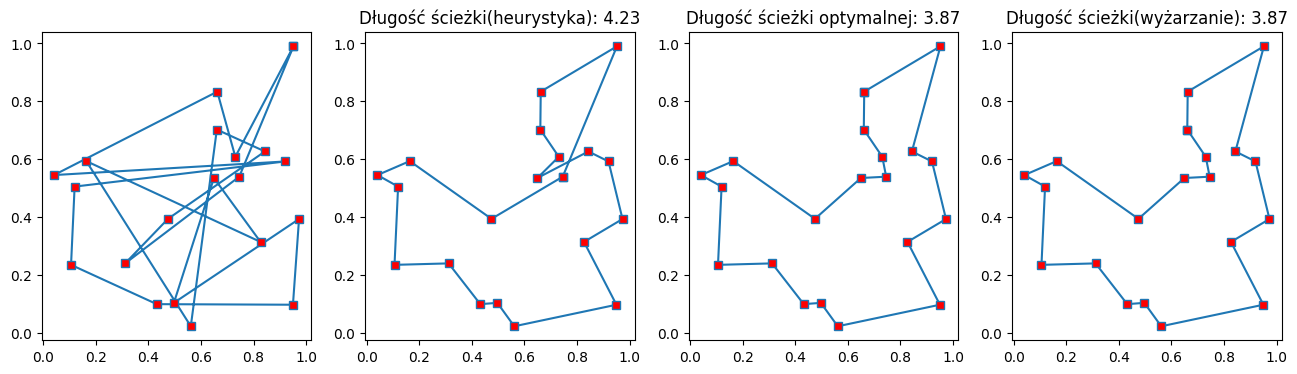

In [53]:
m = 20
sample_points = generate_uniform(m)
shuffle()
draw4(sample_points)

#### Liczba miast = 20, rozkład normalny w czterech punktach

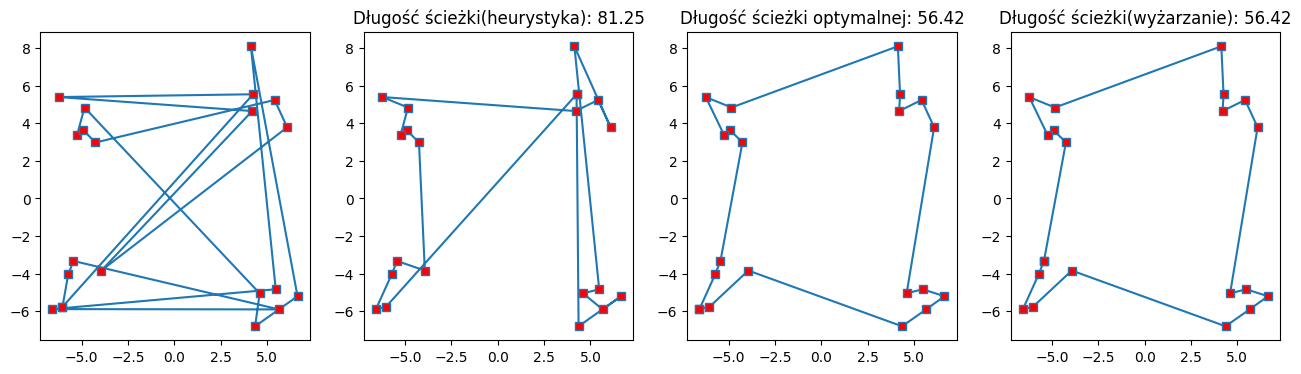

In [37]:
m = 20
sample_points = generate_normal(m // 4)
shuffle()
draw4(sample_points)

#### Liczba miast = 90, 9 grup

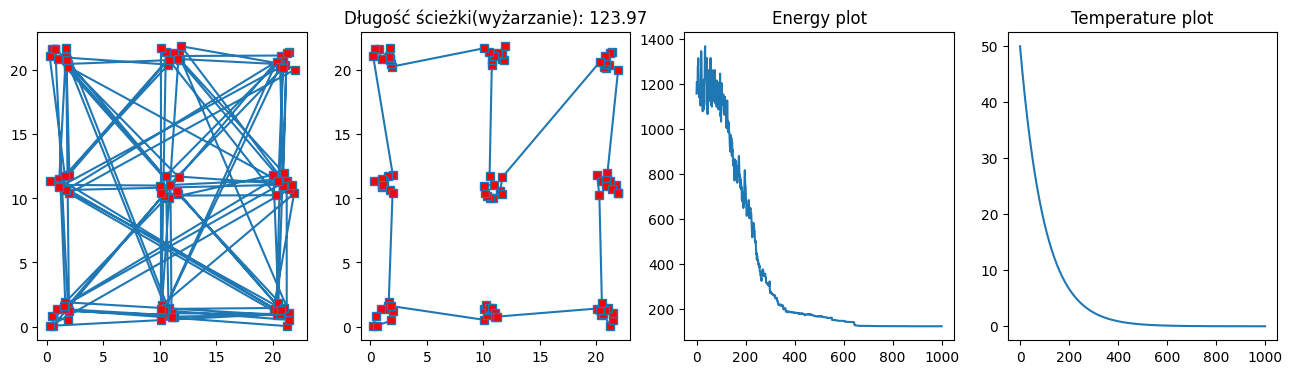

In [54]:
m = 90
sample_points = generate_clusters(m // 9)
shuffle()
draw_with_stats(sample_points)

#### Liczba miast = 200, jednostajny

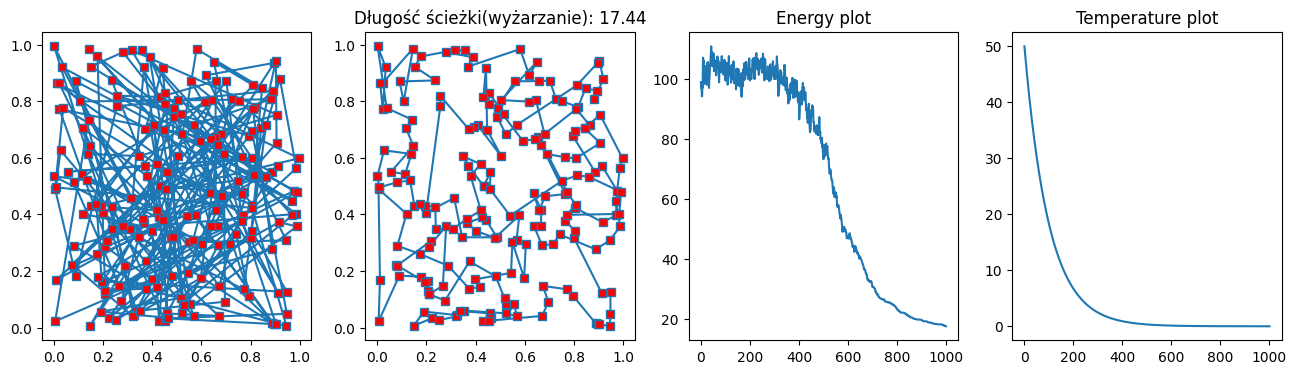

In [55]:
m = 200
sample_points = generate_uniform(m)
shuffle()
draw_with_stats(sample_points)

#### Liczba miast = 100, rozkład normalny

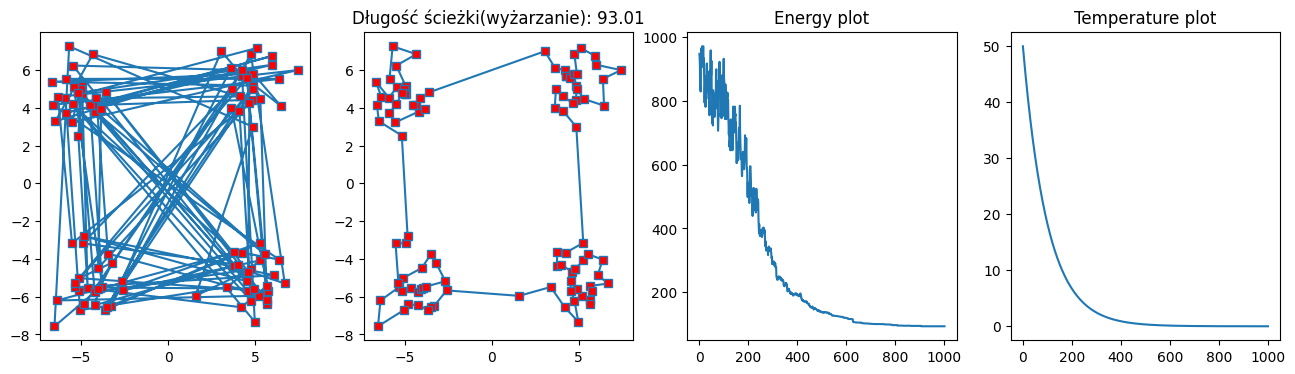

In [57]:
m = 100
sample_points = generate_normal(m // 4)
shuffle()
draw_with_stats(sample_points)

## Porównanie funkcji generującej sąsiadów dla punktów z rozkładu normalnego
Wykresy przedstawiają kolejno: początkowy stan, końcowy stan z użyciem consecutive swap, końcowy stan z użyciem arbitrary swap, końcowy stan z użyciem funkcji odwracającej przedziały. We wcześniejszych wykresach dla wyżarzania użyta była funkcja odwracająca przedziały.

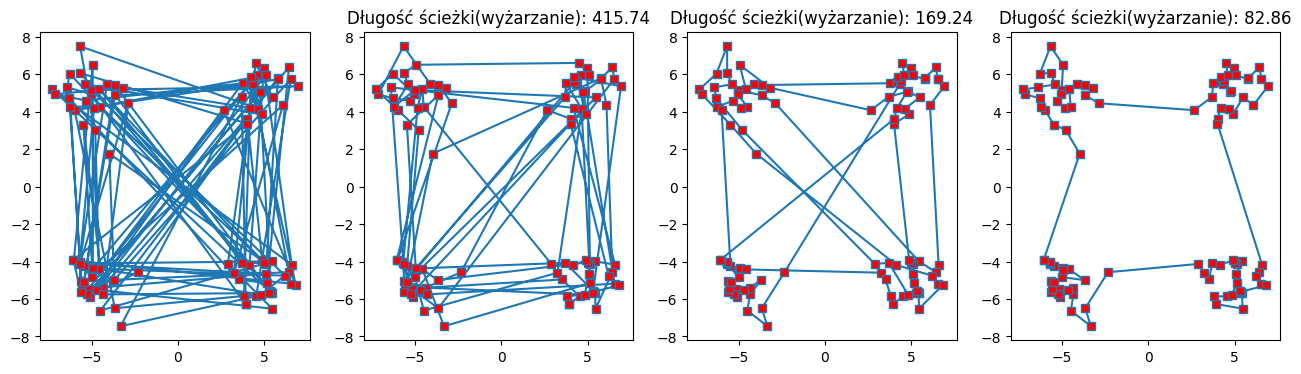

In [17]:
m = 100
sample_points = generate_normal(m // 4)
shuffle()
draw_different_neighbors(sample_points)

### Wykresy tylko dla consecutive swap

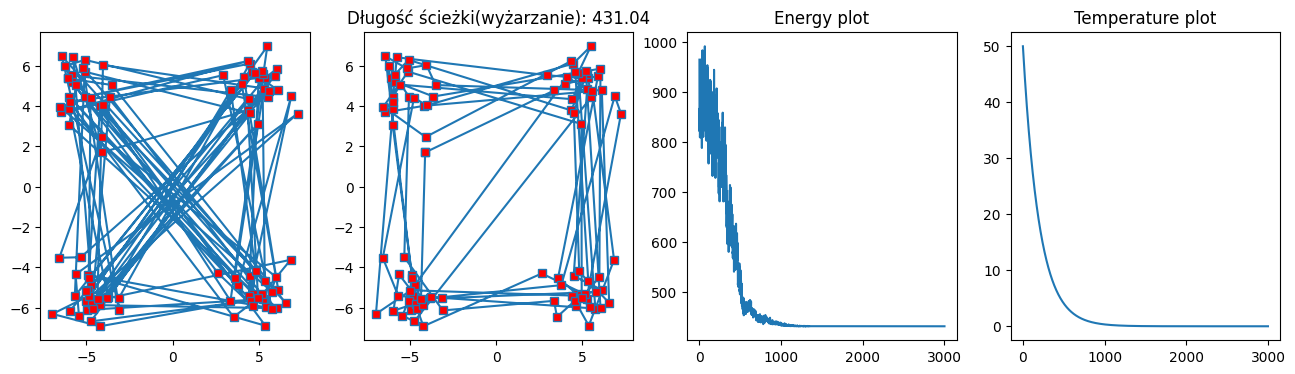

In [25]:
m = 100
sample_points = generate_normal(m // 4)
shuffle()
draw_with_stats(sample_points, neighbor_fun=generate_neighbor1, steps=3000, no_of_iter=80, alpha=0.995)

### Wykresy tylko dla arbitrary swap

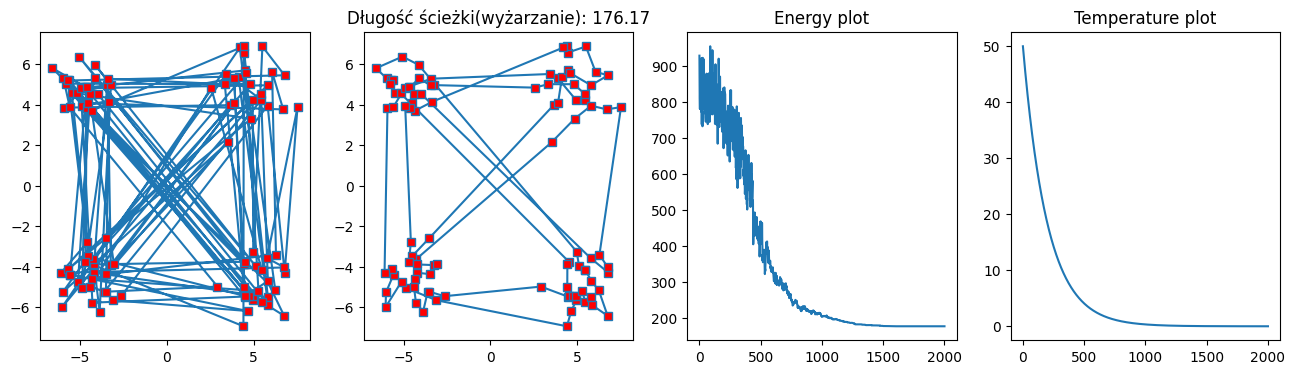

In [28]:
m = 100
sample_points = generate_normal(m // 4)
shuffle()
draw_with_stats(sample_points, neighbor_fun=generate_neighbor2, steps=2000, no_of_iter=60, alpha=0.995)

### Wykresy dla funkcji 3

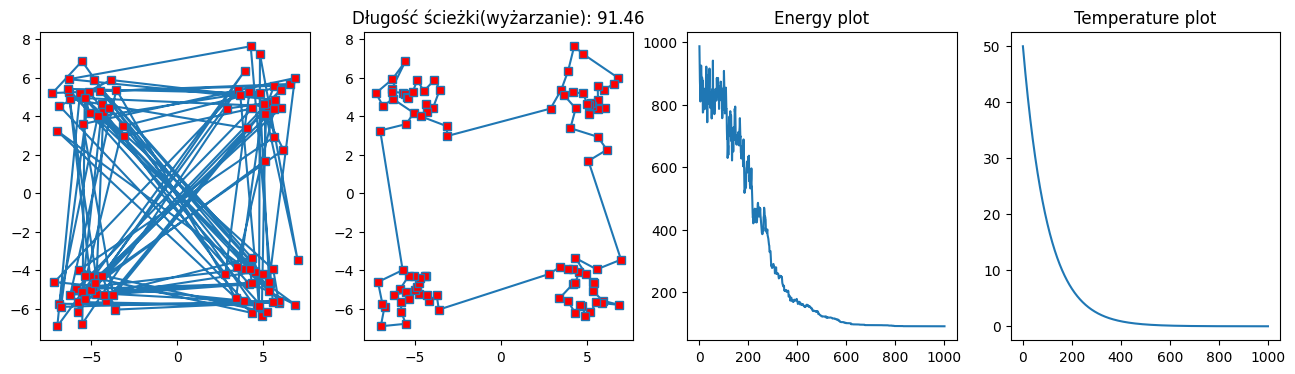

In [32]:
m = 100
sample_points = generate_normal(m // 4)
shuffle()
draw_with_stats(sample_points, neighbor_fun=generate_neighbor3)

### Porównanie funkcji dla rozkładu jednostajnego
Kolejność wykresów analogiczna do poprzedniego wykresu

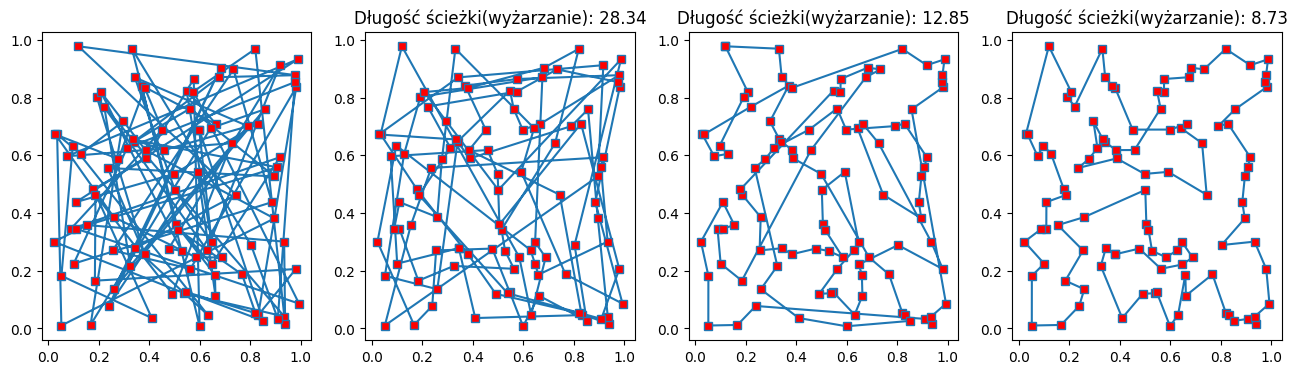

In [29]:
m = 100
sample_points = generate_uniform(m)
shuffle()
draw_different_neighbors(sample_points)

### Wykresy tylko dla consecutive swap

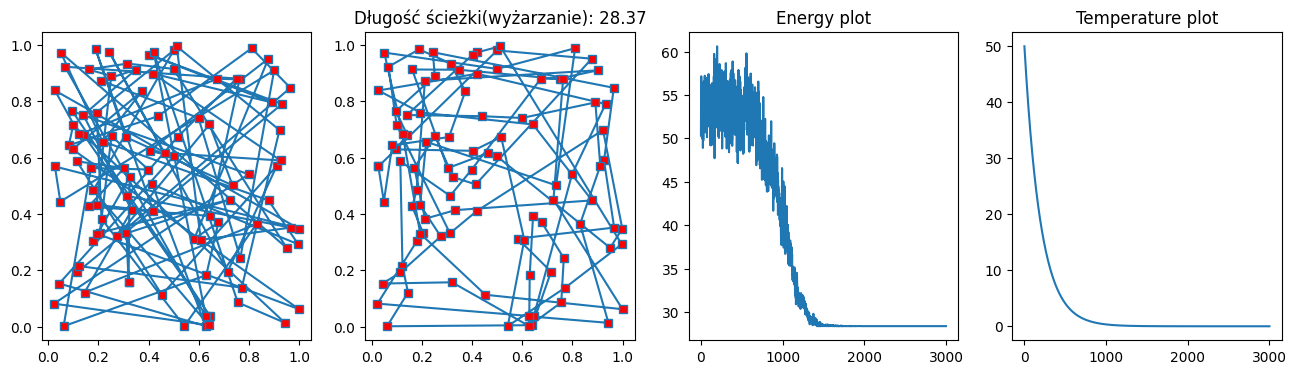

In [33]:
m = 100
sample_points = generate_uniform(m)
shuffle()
draw_with_stats(sample_points, neighbor_fun=generate_neighbor1, steps=3000, no_of_iter=80, alpha=0.995)

### Wykresy tylko dla arbitrary swap

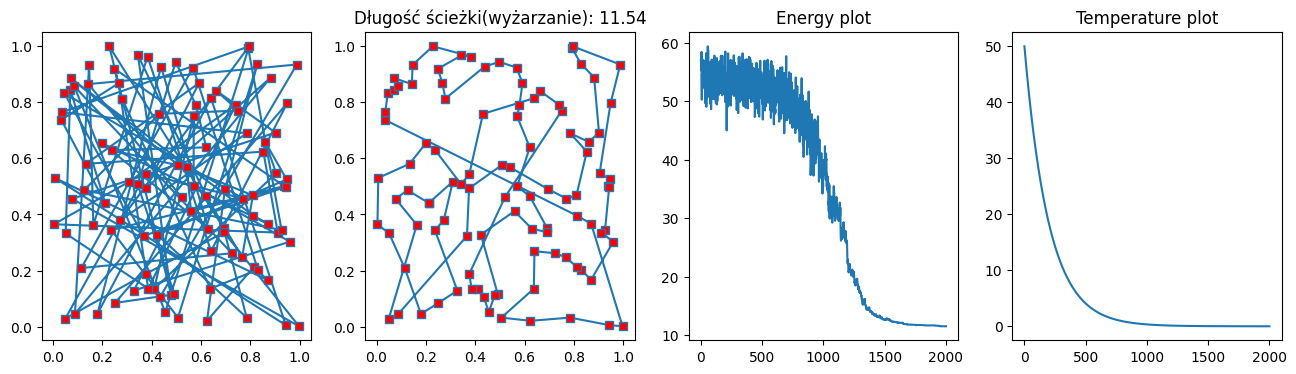

In [34]:
m = 100
sample_points = generate_uniform(m)
shuffle()
draw_with_stats(sample_points, neighbor_fun=generate_neighbor2, steps=2000, no_of_iter=60, alpha=0.995)

### Wykresy tylko dla funkcji 3

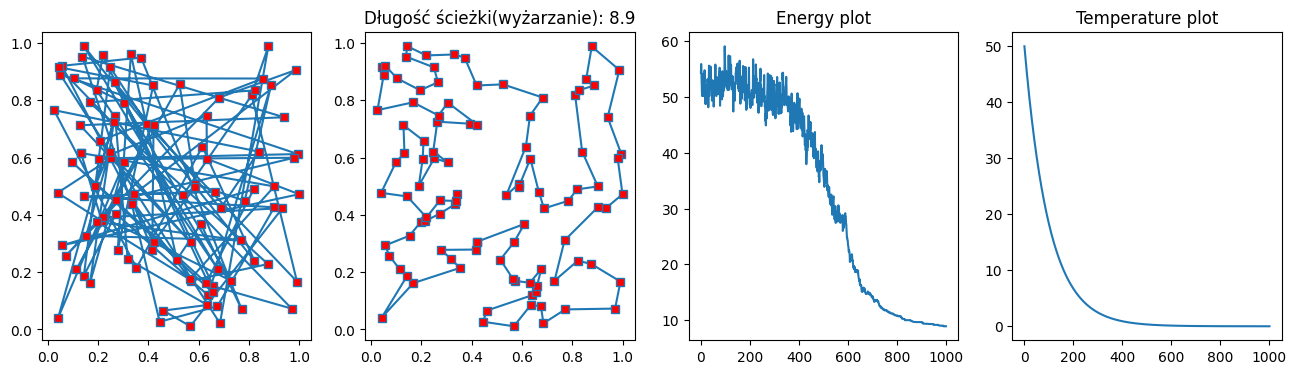

In [35]:
m = 100
sample_points = generate_uniform(m)
shuffle()
draw_with_stats(sample_points, neighbor_fun=generate_neighbor3)

### Wnioski

Praktycznie w każdym przypadku najlepsza okazała się funkcja, która odwracała kolejność miast na całym przedziale. Pozostałe dwie funkcje miały już dużo gorsze wyniki. Zazwyczaj lepszy rezultat znajdował algorytm, który zawsze szedł do najbliższego miasta. Działanie tych funkcji nie poprawiało się też znacząco przy wielu innych doborach parametrów.
Zmiana funkcji temperatury z wykładniczej na $\frac{1}{x}$ jedynie pogorszyło ostateczne wyniki.

## Animacja procesu wyżarzania

#### Rozkład normalny, 100 miast

<img src="annealing_gifs/normal.gif" width="500" align="center">

#### Rozkład jendostajny, 100 miast

<img src="annealing_gifs/uniform.gif" width="500" align="center">